# Detecting malicious URLs

In [15]:
# GENERAL
import os
import math
import re
import datetime
import time
import pandas as pd
import matplotlib as plt
import seaborn as sns
from tqdm import tqdm

For this experiment, we will be using the Sklearn and Fast.ai libraries to assist us across the data science process.

In [129]:
# SKLEARN
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, f1_score ,recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [17]:
# Fast.ai
from fastai.tabular import *
# from fastai.column_data import *

In [18]:
# Models
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

Here we import some libraries to assist us in pulling, parsing, and transforming our domain information.

In [19]:
# DOMAIN SPECIFIC LIBRARIES
import tldextract
from datetime import datetime
import warnings
from urllib.parse import urlparse
from socket import gethostbyname, gaierror, timeout
import whois
import socket

In [20]:
# iPython and Notebook config
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #display all results

%config InlineBackend.figure_format = 'retina' #see plots in retina displays
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Data Ingestion

### The bad stuff

Exploring the Internet, we find a nice list of maliciousness, provided by http://www.malwaredomainlist.com/

Link: http://www.malwaredomainlist.com/hostslist/hosts.txt

In [5]:
# Ingest malicious urls from malwaredomainlist
columns = ['ip', 'url']

mal_df = pd.read_csv('../data/hosts.txt', 
                     delimiter = '\s+', 
                     encoding = "ISO-8859-1", 
                     skiprows=6,
                     names = columns)[['url']]

In [ ]:
# Randomly sample 500 elements from your dataframe
mal_sample_df = mal_df.sample(n=1500)

In [25]:
mal_sample_df = pd.read_csv("malicious_1000.csv", index_col=0)
mal_sample_df.head()

,url,class,domain_creation,domain_update,host_ip,specials,domain,suffix,domain_name,prefix,entropy
977,www.infra.by,malicious,2019-07-12 16:59:28,2019-07-12 17:55:31,91.149.157.185,2,infra,by,infra.by,91,3.022055
997,www.northpoleitalia.it,malicious,2018-08-29 12:02:06,2018-08-29 12:06:08,165.231.200.49,2,northpoleitalia,it,northpoleitalia.it,165,3.447402
452,nowina.info,malicious,2003-11-07 10:58:16,2018-10-24 08:42:08,185.18.29.3,1,nowina,info,nowina.info,185,2.663533
1087,xorgwebs.webs.com,malicious,1995-04-04 04:00:00,2017-03-03 17:11:11,104.17.119.40,2,webs,com,webs.com,104,3.381580
74,beautysafari.com,malicious,2019-04-26 18:51:18,2019-04-26 18:51:27,23.20.239.12,1,beautysafari,com,beautysafari.com,23,3.702820


In [181]:
w = whois.whois('baidu.com')

In [ ]:
mal_sample_df['class'] = 'malicious'

In [ ]:
mal_sample_df.head()

### The mostly benign stuff

In [ ]:
# Ingest Alex top 1 million urls 
columns = ['url']

benign_df = pd.read_csv('../data/top-1m.csv', 
                     encoding = "ISO-8859-1", 
                     names = columns)

In [ ]:
benign_sample_df = benign_df.iloc[0:1000]

In [ ]:
benign_sample_df['class'] = 'benign'

In [26]:
benign_sample_df = pd.read_csv("benign_1000.csv", index_col=0)

In [27]:
benign_sample_df.head()

,url,class,domain_creation,domain_update,host_ip,specials,domain,suffix,domain_name,prefix,entropy
1,google.com,benign,1997-09-15 04:00:00.000,2018-02-21 18:36:40.000,216.58.196.142,1,google,com,google.com,216,2.646439
2,youtube.com,benign,2005-02-15 05:13:12.000,2019-01-14 10:32:15.000,216.58.200.110,1,youtube,com,youtube.com,216,3.095795
3,baidu.com,benign,1999-10-11 11:05:17.000,2019-05-09 04:30:46.000,123.125.114.144,1,baidu,com,baidu.com,123,3.169925
4,facebook.com,benign,1997-03-29 05:00:00.000,2018-07-23 18:17:13.000,157.240.8.35,1,facebook,com,facebook.com,157,3.022055
5,qq.com,benign,1995-05-04 04:00:00.000,2019-07-11 03:13:45.000,111.161.64.40,1,qq,com,qq.com,111,2.251629


### Data Enrichment

In [42]:
# Ingest IANA dataset
iana = pd.read_csv("https://www.iana.org/assignments/ipv4-address-space/ipv4-address-space.csv", sep=",")
iana.columns = iana.columns.str.strip().str.lower()
iana.rename(columns={'Prefix': 'prefix'}, inplace=True)

# Clean up prefix since it uses old/BSD formatting
iana['prefix']= iana['prefix'].apply(lambda x: re.sub('^(00|0)','',x))
iana['prefix'] = iana['prefix'].apply(lambda x: re.sub('/8$','',x))
iana['prefix'] = pd.to_numeric(iana['prefix'], downcast='float', errors='ignore').astype(int).astype(str)

iana.head()

,prefix,designation,date,whois,rdap,status [1],note
0,0,IANA - Local Identification,1981-09,NaN,NaN,RESERVED,[2]
1,1,APNIC,2010-01,whois.apnic.net,https://rdap.apnic.net/,ALLOCATED,NaN
2,2,RIPE NCC,2009-09,whois.ripe.net,https://rdap.db.ripe.net/,ALLOCATED,NaN
3,3,Administered by ARIN,1994-05,whois.arin.net,https://rdap.arin.net/registry\nhttp://rdap.ar...,LEGACY,NaN
4,4,"Level 3 Parent, LLC",1992-12,whois.arin.net,https://rdap.arin.net/registry\nhttp://rdap.ar...,LEGACY,NaN


In [227]:
# Frames we would like to merge
full_data = [mal_sample_df, benign_sample_df]
print(mal_sample_df.shape, benign_sample_df.shape)

(1000, 11) (1000, 11)


In [228]:
tqdm.pandas()

def whois_info(row):
    """
    Gets whois info for a domain
    """
    
    try:
        whois_info = whois.whois(row['url'])
        creation_date = whois_info.creation_date
        updated_date = whois_info.updated_date
        expiration_date = whois_info.expiration_date
        state = whois_info.state
        country = whois_info.country
        status = whois_info.status
        emails = whois_info.emails
        whois_server = whois_info.whois_server
        registrar = whois_info.registrar

        return pd.Series({"creation_date": creation_date, 
                          "updated_date": updated_date, 
                          "expiration_date": expiration_date,
                          "state": state, 
                          "country": country, 
                          "status": status,
                          "emails": emails,
                          "whois_server": whois_server,
                          "registrar": registrar,
                         })
    
    except (whois.parser.PywhoisError, gaierror, socket.timeout, socket.error):
        creation_date = None
        updated_date = None
        expiration_date = None
        state = None
        country = None
        status = None
        emails = None
        whois_server = None
        registrar = None
        
    return pd.Series({"creation_date": creation_date, 
                      "updated_date": updated_date, 
                      "expiration_date": expiration_date,
                      "state": state, 
                      "country": country, 
                      "status": status,
                      "emails": emails,
                      "whois_server": whois_server,
                      "registrar": registrar,
                     })

for df in full_data:
    df[['create_date', 
          'updated_date', 
          'expiration_date', 
          'state', 
          'country', 
          'status', 
          'emails', 
          'whois_server', 
          'registrar']]  = df.progress_apply(whois_info, axis=1)













  0%|          | 0/1000 [00:00<?, ?it/s]











  0%|          | 2/1000 [00:00<06:17,  2.65it/s]











  0%|          | 3/1000 [00:01<07:47,  2.13it/s]











  0%|          | 4/1000 [00:02<11:30,  1.44it/s]











  0%|          | 5/1000 [00:03<12:54,  1.28it/s]











  1%|          | 6/1000 [00:05<15:55,  1.04it/s]











  1%|          | 7/1000 [00:05<15:44,  1.05it/s]











  1%|          | 8/1000 [00:06<12:47,  1.29it/s]











  1%|          | 9/1000 [00:07<13:15,  1.25it/s]











  1%|          | 10/1000 [00:08<13:57,  1.18it/s]











  1%|          | 11/1000 [00:10<23:28,  1.42s/it]











  1%|          | 12/1000 [00:11<20:13,  1.23s/it]











  1%|▏         | 13/1000 [00:12<18:22,  1.12s/it]











  1%|▏         | 14/1000 [00:13<17:16,  1.05s/it]











  2%|▏         | 15/1000 [00:14<16:14,  1.01it/s]











  2%|▏         | 16/1000 [00:15<18:58,  1.16s/it]











  2%|▏         | 17/1000 [00:

  8%|▊         | 85/1000 [03:32<31:24,  2.06s/it]











  9%|▊         | 86/1000 [03:33<30:33,  2.01s/it]











  9%|▊         | 87/1000 [03:36<30:58,  2.04s/it]











  9%|▉         | 88/1000 [03:36<24:35,  1.62s/it]











  9%|▉         | 89/1000 [03:47<1:08:17,  4.50s/it]











  9%|▉         | 90/1000 [03:49<54:09,  3.57s/it]  











  9%|▉         | 91/1000 [03:50<43:32,  2.87s/it]











  9%|▉         | 92/1000 [03:54<47:26,  3.13s/it]











  9%|▉         | 93/1000 [03:55<37:20,  2.47s/it]











  9%|▉         | 94/1000 [03:57<36:32,  2.42s/it]











 10%|▉         | 95/1000 [03:58<30:09,  2.00s/it]











 10%|▉         | 96/1000 [03:59<24:02,  1.60s/it]











 10%|▉         | 97/1000 [04:02<29:37,  1.97s/it]











 10%|▉         | 98/1000 [04:03<28:53,  1.92s/it]











 10%|▉         | 99/1000 [04:04<23:26,  1.56s/it]











 10%|█         | 100/1000 [04:05<19:31,  1.30s/it]











 10%|█         | 10

 17%|█▋        | 168/1000 [07:14<14:12,  1.03s/it]











 17%|█▋        | 169/1000 [07:15<13:31,  1.02it/s]











 17%|█▋        | 170/1000 [07:16<12:54,  1.07it/s]











 17%|█▋        | 171/1000 [07:17<13:35,  1.02it/s]











 17%|█▋        | 172/1000 [07:18<15:47,  1.14s/it]











 17%|█▋        | 173/1000 [07:19<14:01,  1.02s/it]











 17%|█▋        | 174/1000 [07:20<13:12,  1.04it/s]











 18%|█▊        | 175/1000 [07:21<16:12,  1.18s/it]











 18%|█▊        | 176/1000 [07:23<16:00,  1.17s/it]











 18%|█▊        | 177/1000 [07:23<14:12,  1.04s/it]











 18%|█▊        | 178/1000 [07:25<16:41,  1.22s/it]











 18%|█▊        | 179/1000 [07:25<13:09,  1.04it/s]











 18%|█▊        | 180/1000 [07:26<11:59,  1.14it/s]











 18%|█▊        | 181/1000 [07:27<12:41,  1.07it/s]











 18%|█▊        | 182/1000 [07:28<12:36,  1.08it/s]











 18%|█▊        | 183/1000 [07:30<18:18,  1.34s/it]











 18%|█▊ 

 25%|██▌       | 251/1000 [09:46<16:58,  1.36s/it]











 25%|██▌       | 252/1000 [09:49<24:30,  1.97s/it]











 25%|██▌       | 253/1000 [09:50<19:47,  1.59s/it]











 25%|██▌       | 254/1000 [09:51<16:21,  1.32s/it]











 26%|██▌       | 255/1000 [09:51<12:54,  1.04s/it]











 26%|██▌       | 256/1000 [09:52<12:15,  1.01it/s]











 26%|██▌       | 257/1000 [09:53<12:37,  1.02s/it]











 26%|██▌       | 258/1000 [09:54<12:16,  1.01it/s]











 26%|██▌       | 259/1000 [09:55<11:47,  1.05it/s]











 26%|██▌       | 260/1000 [09:56<12:29,  1.01s/it]











 26%|██▌       | 261/1000 [09:57<11:15,  1.09it/s]











 26%|██▌       | 262/1000 [09:58<12:04,  1.02it/s]











 26%|██▋       | 263/1000 [09:58<09:47,  1.25it/s]











 26%|██▋       | 264/1000 [09:59<09:57,  1.23it/s]











 26%|██▋       | 265/1000 [10:00<10:13,  1.20it/s]











 27%|██▋       | 266/1000 [10:01<11:25,  1.07it/s]











 27%|██▋

 33%|███▎      | 334/1000 [12:23<46:10,  4.16s/it]  











 34%|███▎      | 335/1000 [12:24<34:33,  3.12s/it]











 34%|███▎      | 336/1000 [12:28<38:35,  3.49s/it]











 34%|███▎      | 337/1000 [12:29<31:39,  2.87s/it]











 34%|███▍      | 338/1000 [12:32<31:45,  2.88s/it]











 34%|███▍      | 339/1000 [12:33<23:24,  2.12s/it]











 34%|███▍      | 340/1000 [13:03<1:55:22, 10.49s/it]











 34%|███▍      | 341/1000 [13:04<1:24:59,  7.74s/it]











 34%|███▍      | 342/1000 [13:04<1:01:00,  5.56s/it]











 34%|███▍      | 343/1000 [13:06<47:07,  4.30s/it]  











 34%|███▍      | 344/1000 [13:08<40:39,  3.72s/it]











 34%|███▍      | 345/1000 [13:09<31:25,  2.88s/it]











 35%|███▍      | 346/1000 [13:10<24:11,  2.22s/it]











 35%|███▍      | 347/1000 [13:12<23:11,  2.13s/it]











 35%|███▍      | 348/1000 [13:12<18:24,  1.69s/it]











 35%|███▍      | 349/1000 [13:13<16:11,  1.49s/it]











 42%|████▏     | 418/1000 [14:39<08:04,  1.20it/s]











 42%|████▏     | 419/1000 [14:41<10:33,  1.09s/it]











 42%|████▏     | 420/1000 [14:42<09:52,  1.02s/it]











 42%|████▏     | 421/1000 [14:43<08:50,  1.09it/s]











 42%|████▏     | 422/1000 [14:43<08:32,  1.13it/s]











 42%|████▏     | 423/1000 [14:44<09:06,  1.06it/s]











 42%|████▏     | 424/1000 [14:45<07:24,  1.30it/s]











 42%|████▎     | 425/1000 [14:45<06:53,  1.39it/s]











 43%|████▎     | 426/1000 [14:46<07:28,  1.28it/s]











 43%|████▎     | 427/1000 [14:48<10:23,  1.09s/it]











 43%|████▎     | 428/1000 [14:49<10:35,  1.11s/it]











 43%|████▎     | 429/1000 [14:50<09:57,  1.05s/it]











 43%|████▎     | 430/1000 [14:51<09:59,  1.05s/it]











 43%|████▎     | 431/1000 [14:52<08:41,  1.09it/s]











 43%|████▎     | 432/1000 [14:53<08:44,  1.08it/s]











 43%|████▎     | 433/1000 [14:54<09:08,  1.03it/s]











 43%|███

 50%|█████     | 503/1000 [17:14<06:56,  1.19it/s]











 50%|█████     | 504/1000 [17:15<05:51,  1.41it/s]











 50%|█████     | 505/1000 [17:16<07:59,  1.03it/s]











 51%|█████     | 506/1000 [17:17<07:46,  1.06it/s]











 51%|█████     | 507/1000 [17:18<07:51,  1.05it/s]











 51%|█████     | 508/1000 [17:19<08:07,  1.01it/s]











 51%|█████     | 509/1000 [17:21<10:45,  1.32s/it]











 51%|█████     | 510/1000 [17:22<09:27,  1.16s/it]











 51%|█████     | 511/1000 [17:24<10:45,  1.32s/it]











 51%|█████     | 512/1000 [17:25<09:36,  1.18s/it]











 51%|█████▏    | 513/1000 [17:26<08:38,  1.07s/it]











 51%|█████▏    | 514/1000 [17:27<08:35,  1.06s/it]











 52%|█████▏    | 515/1000 [17:28<10:04,  1.25s/it]











 52%|█████▏    | 516/1000 [17:29<08:50,  1.10s/it]











 52%|█████▏    | 517/1000 [17:31<12:11,  1.51s/it]











 52%|█████▏    | 518/1000 [17:32<09:24,  1.17s/it]











 52%|███

 59%|█████▊    | 587/1000 [18:54<08:01,  1.17s/it]











 59%|█████▉    | 588/1000 [18:54<06:26,  1.07it/s]











 59%|█████▉    | 589/1000 [18:55<06:16,  1.09it/s]











 59%|█████▉    | 590/1000 [18:56<06:15,  1.09it/s]











 59%|█████▉    | 591/1000 [18:58<07:55,  1.16s/it]











 59%|█████▉    | 592/1000 [18:59<07:31,  1.11s/it]











 59%|█████▉    | 593/1000 [18:59<06:49,  1.01s/it]











 59%|█████▉    | 594/1000 [19:00<06:41,  1.01it/s]











 60%|█████▉    | 595/1000 [19:02<06:57,  1.03s/it]











 60%|█████▉    | 596/1000 [19:02<06:36,  1.02it/s]











 60%|█████▉    | 597/1000 [19:03<05:22,  1.25it/s]











 60%|█████▉    | 598/1000 [19:03<04:29,  1.49it/s]











 60%|█████▉    | 599/1000 [19:04<04:44,  1.41it/s]











 60%|██████    | 600/1000 [19:05<05:41,  1.17it/s]











 60%|██████    | 601/1000 [19:06<05:59,  1.11it/s]











 60%|██████    | 602/1000 [19:08<06:55,  1.04s/it]











 60%|███

 67%|██████▋   | 670/1000 [20:31<04:00,  1.37it/s]











 67%|██████▋   | 671/1000 [20:32<04:22,  1.25it/s]











 67%|██████▋   | 672/1000 [20:33<04:26,  1.23it/s]











 67%|██████▋   | 673/1000 [20:33<03:41,  1.48it/s]











 67%|██████▋   | 674/1000 [20:35<04:29,  1.21it/s]











 68%|██████▊   | 675/1000 [21:05<51:54,  9.58s/it]











 68%|██████▊   | 676/1000 [21:06<38:41,  7.17s/it]











 68%|██████▊   | 677/1000 [21:36<1:15:28, 14.02s/it]











 68%|██████▊   | 678/1000 [21:37<53:57, 10.06s/it]  











 68%|██████▊   | 679/1000 [21:39<41:34,  7.77s/it]











 68%|██████▊   | 680/1000 [21:40<30:16,  5.68s/it]











 68%|██████▊   | 681/1000 [21:41<21:42,  4.08s/it]











 68%|██████▊   | 682/1000 [21:43<18:23,  3.47s/it]











 68%|██████▊   | 683/1000 [21:43<13:24,  2.54s/it]











 68%|██████▊   | 684/1000 [22:13<56:46, 10.78s/it]











 68%|██████▊   | 685/1000 [22:13<40:11,  7.66s/it]











 69%

 75%|███████▌  | 754/1000 [24:40<02:42,  1.51it/s]











 76%|███████▌  | 755/1000 [24:41<03:22,  1.21it/s]











 76%|███████▌  | 756/1000 [24:42<03:26,  1.18it/s]











 76%|███████▌  | 757/1000 [24:43<03:38,  1.11it/s]











 76%|███████▌  | 758/1000 [24:45<04:39,  1.15s/it]











 76%|███████▌  | 759/1000 [24:48<06:34,  1.64s/it]











 76%|███████▌  | 760/1000 [24:49<05:25,  1.36s/it]











 76%|███████▌  | 761/1000 [24:50<04:50,  1.22s/it]











 76%|███████▌  | 762/1000 [24:50<04:32,  1.15s/it]











 76%|███████▋  | 763/1000 [24:52<04:44,  1.20s/it]











 76%|███████▋  | 764/1000 [24:53<04:56,  1.26s/it]











 76%|███████▋  | 765/1000 [24:54<04:22,  1.12s/it]











 77%|███████▋  | 766/1000 [24:55<04:47,  1.23s/it]











 77%|███████▋  | 767/1000 [24:57<04:34,  1.18s/it]











 77%|███████▋  | 768/1000 [24:57<03:23,  1.14it/s]











 77%|███████▋  | 769/1000 [24:57<02:47,  1.38it/s]











 77%|███

 84%|████████▎ | 837/1000 [26:45<02:47,  1.02s/it]











 84%|████████▍ | 838/1000 [26:46<02:39,  1.01it/s]











 84%|████████▍ | 839/1000 [26:47<02:58,  1.11s/it]











 84%|████████▍ | 840/1000 [26:48<03:02,  1.14s/it]











 84%|████████▍ | 841/1000 [26:49<03:01,  1.14s/it]











 84%|████████▍ | 842/1000 [26:50<02:50,  1.08s/it]











 84%|████████▍ | 843/1000 [26:51<02:16,  1.15it/s]











 84%|████████▍ | 844/1000 [26:52<02:15,  1.15it/s]











 84%|████████▍ | 845/1000 [26:53<02:15,  1.14it/s]











 85%|████████▍ | 846/1000 [26:54<02:23,  1.07it/s]











 85%|████████▍ | 847/1000 [27:04<09:40,  3.80s/it]











 85%|████████▍ | 848/1000 [27:05<07:31,  2.97s/it]











 85%|████████▍ | 849/1000 [27:08<07:37,  3.03s/it]











 85%|████████▌ | 850/1000 [27:10<06:21,  2.54s/it]











 85%|████████▌ | 851/1000 [27:11<05:03,  2.04s/it]











 85%|████████▌ | 852/1000 [27:13<05:21,  2.17s/it]











 85%|███

 92%|█████████▏| 921/1000 [29:10<01:28,  1.13s/it]











 92%|█████████▏| 922/1000 [29:11<01:26,  1.11s/it]











 92%|█████████▏| 923/1000 [29:11<01:08,  1.12it/s]











 92%|█████████▏| 924/1000 [29:12<01:11,  1.06it/s]











 92%|█████████▎| 925/1000 [29:14<01:13,  1.02it/s]











 93%|█████████▎| 926/1000 [29:15<01:16,  1.03s/it]











 93%|█████████▎| 927/1000 [29:15<01:07,  1.08it/s]











 93%|█████████▎| 928/1000 [29:17<01:17,  1.07s/it]











 93%|█████████▎| 929/1000 [29:18<01:14,  1.05s/it]











 93%|█████████▎| 930/1000 [29:18<01:06,  1.06it/s]











 93%|█████████▎| 931/1000 [29:20<01:17,  1.12s/it]











 93%|█████████▎| 932/1000 [29:22<01:33,  1.38s/it]











 93%|█████████▎| 933/1000 [29:22<01:13,  1.09s/it]











 93%|█████████▎| 934/1000 [29:24<01:17,  1.18s/it]











 94%|█████████▎| 935/1000 [29:24<01:07,  1.03s/it]











 94%|█████████▎| 936/1000 [29:26<01:11,  1.11s/it]











 94%|███

  0%|          | 4/1000 [00:03<12:32,  1.32it/s]











  0%|          | 5/1000 [00:03<13:13,  1.25it/s]











  1%|          | 6/1000 [00:05<15:36,  1.06it/s]











  1%|          | 7/1000 [00:06<15:46,  1.05it/s]











  1%|          | 8/1000 [00:08<22:45,  1.38s/it]











  1%|          | 9/1000 [00:10<25:04,  1.52s/it]











  1%|          | 10/1000 [00:11<23:10,  1.40s/it]











  1%|          | 11/1000 [00:12<20:37,  1.25s/it]











  1%|          | 12/1000 [00:13<18:39,  1.13s/it]











  1%|▏         | 13/1000 [00:14<17:35,  1.07s/it]











  1%|▏         | 14/1000 [00:15<19:48,  1.21s/it]











  2%|▏         | 15/1000 [00:16<18:13,  1.11s/it]











  2%|▏         | 16/1000 [00:17<16:17,  1.01it/s]











  2%|▏         | 17/1000 [00:18<15:58,  1.03it/s]











  2%|▏         | 18/1000 [00:21<25:08,  1.54s/it]











  2%|▏         | 19/1000 [00:22<22:32,  1.38s/it]











  2%|▏         | 20/1000 [00:2

  9%|▉         | 88/1000 [02:04<18:30,  1.22s/it]











  9%|▉         | 89/1000 [02:05<17:37,  1.16s/it]











  9%|▉         | 90/1000 [02:08<26:08,  1.72s/it]











  9%|▉         | 91/1000 [02:11<33:57,  2.24s/it]











  9%|▉         | 92/1000 [02:12<27:51,  1.84s/it]











  9%|▉         | 93/1000 [02:13<23:14,  1.54s/it]











  9%|▉         | 94/1000 [02:14<19:46,  1.31s/it]











 10%|▉         | 95/1000 [02:16<22:52,  1.52s/it]











 10%|▉         | 96/1000 [02:17<22:27,  1.49s/it]











 10%|▉         | 97/1000 [02:18<19:55,  1.32s/it]











 10%|▉         | 98/1000 [02:19<17:42,  1.18s/it]











 10%|▉         | 99/1000 [02:20<16:41,  1.11s/it]











 10%|█         | 100/1000 [02:21<14:39,  1.02it/s]











 10%|█         | 101/1000 [02:22<16:30,  1.10s/it]











 10%|█         | 102/1000 [02:23<17:29,  1.17s/it]











 10%|█         | 103/1000 [02:24<17:28,  1.17s/it]











 10%|█         | 104

 17%|█▋        | 172/1000 [03:48<22:45,  1.65s/it]











 17%|█▋        | 173/1000 [03:50<25:46,  1.87s/it]











 17%|█▋        | 174/1000 [03:51<23:56,  1.74s/it]











 18%|█▊        | 175/1000 [03:52<20:31,  1.49s/it]











 18%|█▊        | 176/1000 [03:53<18:09,  1.32s/it]











 18%|█▊        | 177/1000 [03:54<16:04,  1.17s/it]











 18%|█▊        | 178/1000 [03:55<16:38,  1.22s/it]











 18%|█▊        | 179/1000 [03:56<15:28,  1.13s/it]











 18%|█▊        | 180/1000 [03:57<14:36,  1.07s/it]











 18%|█▊        | 181/1000 [03:58<13:58,  1.02s/it]











 18%|█▊        | 182/1000 [03:59<13:08,  1.04it/s]











 18%|█▊        | 183/1000 [04:00<12:56,  1.05it/s]











 18%|█▊        | 184/1000 [04:01<12:22,  1.10it/s]











 18%|█▊        | 185/1000 [04:02<12:08,  1.12it/s]











 19%|█▊        | 186/1000 [04:03<14:35,  1.08s/it]











 19%|█▊        | 187/1000 [04:04<14:34,  1.08s/it]











 19%|█▉ 

 26%|██▌       | 256/1000 [05:42<21:04,  1.70s/it]











 26%|██▌       | 257/1000 [05:43<17:50,  1.44s/it]











 26%|██▌       | 258/1000 [05:44<16:46,  1.36s/it]











 26%|██▌       | 259/1000 [05:45<16:34,  1.34s/it]











 26%|██▌       | 260/1000 [05:48<20:57,  1.70s/it]











 26%|██▌       | 261/1000 [05:49<18:26,  1.50s/it]











 26%|██▌       | 262/1000 [05:50<16:40,  1.36s/it]











 26%|██▋       | 263/1000 [05:52<17:17,  1.41s/it]











 26%|██▋       | 264/1000 [05:53<15:39,  1.28s/it]











 26%|██▋       | 265/1000 [06:03<48:59,  4.00s/it]











 27%|██▋       | 266/1000 [06:04<36:27,  2.98s/it]











 27%|██▋       | 267/1000 [06:05<31:47,  2.60s/it]











 27%|██▋       | 268/1000 [06:06<24:54,  2.04s/it]











 27%|██▋       | 269/1000 [06:07<20:30,  1.68s/it]











 27%|██▋       | 270/1000 [06:08<18:31,  1.52s/it]











 27%|██▋       | 271/1000 [06:09<15:22,  1.27s/it]











 27%|██▋

 34%|███▍      | 339/1000 [07:27<11:32,  1.05s/it]











 34%|███▍      | 340/1000 [07:28<12:56,  1.18s/it]











 34%|███▍      | 341/1000 [07:29<12:45,  1.16s/it]











 34%|███▍      | 342/1000 [07:31<12:56,  1.18s/it]











 34%|███▍      | 343/1000 [07:32<12:01,  1.10s/it]











 34%|███▍      | 344/1000 [07:33<11:35,  1.06s/it]











 35%|███▍      | 346/1000 [07:34<09:58,  1.09it/s]











 35%|███▍      | 347/1000 [07:35<09:47,  1.11it/s]











 35%|███▍      | 348/1000 [07:42<29:35,  2.72s/it]











 35%|███▍      | 349/1000 [07:45<32:42,  3.02s/it]











 35%|███▌      | 350/1000 [07:48<30:46,  2.84s/it]











 35%|███▌      | 351/1000 [07:48<24:14,  2.24s/it]











 35%|███▌      | 353/1000 [07:50<18:44,  1.74s/it]











 35%|███▌      | 354/1000 [07:51<17:50,  1.66s/it]











 36%|███▌      | 355/1000 [07:52<16:22,  1.52s/it]











 36%|███▌      | 356/1000 [07:53<14:38,  1.36s/it]











 36%|███

 42%|████▏     | 424/1000 [09:24<10:12,  1.06s/it]











 42%|████▎     | 425/1000 [09:25<09:28,  1.01it/s]











 43%|████▎     | 426/1000 [09:26<09:07,  1.05it/s]











 43%|████▎     | 428/1000 [09:27<08:19,  1.15it/s]











 43%|████▎     | 429/1000 [09:28<09:05,  1.05it/s]











 43%|████▎     | 430/1000 [09:29<08:37,  1.10it/s]











 43%|████▎     | 431/1000 [09:30<07:47,  1.22it/s]











 43%|████▎     | 432/1000 [09:30<08:04,  1.17it/s]











 43%|████▎     | 433/1000 [09:33<11:26,  1.21s/it]











 43%|████▎     | 434/1000 [09:35<13:47,  1.46s/it]











 44%|████▎     | 435/1000 [09:35<11:40,  1.24s/it]











 44%|████▎     | 436/1000 [09:37<12:28,  1.33s/it]











 44%|████▎     | 437/1000 [09:38<10:55,  1.16s/it]











 44%|████▍     | 438/1000 [09:39<10:11,  1.09s/it]











 44%|████▍     | 439/1000 [09:39<09:17,  1.01it/s]











 44%|████▍     | 440/1000 [09:40<09:02,  1.03it/s]











 44%|███

 51%|█████     | 509/1000 [11:00<11:28,  1.40s/it]











 51%|█████     | 510/1000 [11:01<10:17,  1.26s/it]











 51%|█████     | 511/1000 [11:02<10:56,  1.34s/it]











 51%|█████     | 512/1000 [11:03<10:25,  1.28s/it]











 51%|█████▏    | 513/1000 [11:04<09:29,  1.17s/it]











 51%|█████▏    | 514/1000 [11:05<08:31,  1.05s/it]











 52%|█████▏    | 515/1000 [11:06<09:16,  1.15s/it]











 52%|█████▏    | 516/1000 [11:07<08:17,  1.03s/it]











 52%|█████▏    | 517/1000 [11:08<08:55,  1.11s/it]











 52%|█████▏    | 518/1000 [11:09<08:16,  1.03s/it]











 52%|█████▏    | 519/1000 [11:12<12:22,  1.54s/it]











 52%|█████▏    | 520/1000 [11:13<10:45,  1.34s/it]











 52%|█████▏    | 521/1000 [11:14<09:33,  1.20s/it]











 52%|█████▏    | 522/1000 [11:15<09:47,  1.23s/it]











 52%|█████▏    | 523/1000 [11:16<08:37,  1.08s/it]











 52%|█████▏    | 524/1000 [11:16<06:57,  1.14it/s]











 52%|███

 59%|█████▉    | 594/1000 [13:07<07:50,  1.16s/it]











 60%|█████▉    | 595/1000 [13:08<08:34,  1.27s/it]











 60%|█████▉    | 596/1000 [13:10<08:45,  1.30s/it]











 60%|█████▉    | 597/1000 [13:11<08:02,  1.20s/it]











 60%|█████▉    | 598/1000 [13:12<08:39,  1.29s/it]











 60%|█████▉    | 599/1000 [13:12<06:35,  1.01it/s]











 60%|██████    | 600/1000 [13:14<07:18,  1.10s/it]











 60%|██████    | 601/1000 [13:15<07:20,  1.10s/it]











 60%|██████    | 602/1000 [13:16<06:55,  1.04s/it]











 60%|██████    | 603/1000 [13:17<06:17,  1.05it/s]











 60%|██████    | 604/1000 [13:17<05:53,  1.12it/s]











 60%|██████    | 605/1000 [13:18<06:15,  1.05it/s]











 61%|██████    | 606/1000 [13:19<06:16,  1.05it/s]











 61%|██████    | 607/1000 [13:20<06:26,  1.02it/s]











 61%|██████    | 608/1000 [13:22<06:37,  1.02s/it]











 61%|██████    | 609/1000 [13:23<06:54,  1.06s/it]











 61%|███

 68%|██████▊   | 678/1000 [15:28<13:52,  2.59s/it]











 68%|██████▊   | 679/1000 [15:30<11:58,  2.24s/it]











 68%|██████▊   | 680/1000 [15:31<10:57,  2.05s/it]











 68%|██████▊   | 681/1000 [15:33<10:06,  1.90s/it]











 68%|██████▊   | 682/1000 [15:34<08:31,  1.61s/it]











 68%|██████▊   | 683/1000 [15:35<07:25,  1.40s/it]











 68%|██████▊   | 684/1000 [15:46<23:31,  4.47s/it]











 68%|██████▊   | 685/1000 [15:47<18:09,  3.46s/it]











 69%|██████▊   | 686/1000 [15:48<14:11,  2.71s/it]











 69%|██████▊   | 687/1000 [15:54<18:45,  3.60s/it]











 69%|██████▉   | 688/1000 [15:55<14:32,  2.80s/it]











 69%|██████▉   | 689/1000 [15:56<11:24,  2.20s/it]











 69%|██████▉   | 690/1000 [16:00<14:30,  2.81s/it]











 69%|██████▉   | 691/1000 [16:01<12:20,  2.40s/it]











 69%|██████▉   | 692/1000 [16:03<11:01,  2.15s/it]











 69%|██████▉   | 693/1000 [16:06<11:32,  2.26s/it]











 69%|███

 76%|███████▌  | 762/1000 [17:53<04:07,  1.04s/it]











 76%|███████▋  | 763/1000 [17:54<03:53,  1.01it/s]











 76%|███████▋  | 764/1000 [17:57<06:23,  1.62s/it]











 76%|███████▋  | 765/1000 [17:58<05:47,  1.48s/it]











 77%|███████▋  | 766/1000 [18:00<06:01,  1.55s/it]











 77%|███████▋  | 767/1000 [18:00<05:09,  1.33s/it]











 77%|███████▋  | 768/1000 [18:01<04:38,  1.20s/it]











 77%|███████▋  | 769/1000 [18:03<04:44,  1.23s/it]











 77%|███████▋  | 770/1000 [18:04<04:47,  1.25s/it]











 77%|███████▋  | 771/1000 [18:05<04:21,  1.14s/it]











 77%|███████▋  | 772/1000 [18:15<14:59,  3.95s/it]











 77%|███████▋  | 774/1000 [18:16<11:06,  2.95s/it]











 78%|███████▊  | 775/1000 [18:17<08:42,  2.32s/it]











 78%|███████▊  | 776/1000 [18:18<06:58,  1.87s/it]











 78%|███████▊  | 777/1000 [18:19<06:19,  1.70s/it]











 78%|███████▊  | 778/1000 [18:21<05:49,  1.57s/it]











 78%|███

 85%|████████▍ | 846/1000 [20:10<05:43,  2.23s/it]











 85%|████████▍ | 847/1000 [20:12<05:50,  2.29s/it]











 85%|████████▍ | 848/1000 [20:15<06:16,  2.47s/it]











 85%|████████▍ | 849/1000 [20:16<05:11,  2.06s/it]











 85%|████████▌ | 850/1000 [20:17<04:14,  1.70s/it]











 85%|████████▌ | 851/1000 [20:19<04:01,  1.62s/it]











 85%|████████▌ | 852/1000 [20:20<03:31,  1.43s/it]











 85%|████████▌ | 853/1000 [20:21<03:16,  1.34s/it]











 85%|████████▌ | 854/1000 [20:22<03:07,  1.29s/it]











 86%|████████▌ | 855/1000 [20:23<02:47,  1.15s/it]











 86%|████████▌ | 856/1000 [20:24<02:42,  1.13s/it]











 86%|████████▌ | 857/1000 [20:25<02:45,  1.16s/it]











 86%|████████▌ | 858/1000 [20:26<02:32,  1.07s/it]











 86%|████████▌ | 859/1000 [20:27<02:31,  1.07s/it]











 86%|████████▌ | 860/1000 [20:28<02:47,  1.20s/it]











 86%|████████▌ | 861/1000 [20:29<02:33,  1.10s/it]











 86%|███

 93%|█████████▎| 931/1000 [22:43<05:25,  4.71s/it]











 93%|█████████▎| 932/1000 [22:44<04:14,  3.74s/it]











 93%|█████████▎| 933/1000 [22:45<03:25,  3.07s/it]











 93%|█████████▎| 934/1000 [22:49<03:35,  3.27s/it]











 94%|█████████▎| 935/1000 [22:52<03:21,  3.10s/it]











 94%|█████████▎| 936/1000 [22:53<02:48,  2.63s/it]











 94%|█████████▎| 937/1000 [22:55<02:19,  2.22s/it]











 94%|█████████▍| 938/1000 [22:56<01:57,  1.89s/it]











 94%|█████████▍| 939/1000 [22:58<02:04,  2.04s/it]











 94%|█████████▍| 940/1000 [22:59<01:48,  1.80s/it]











 94%|█████████▍| 941/1000 [23:01<01:38,  1.68s/it]











 94%|█████████▍| 942/1000 [23:02<01:27,  1.51s/it]











 94%|█████████▍| 943/1000 [23:03<01:25,  1.49s/it]











 94%|█████████▍| 944/1000 [23:07<01:58,  2.11s/it]











 94%|█████████▍| 945/1000 [23:09<01:49,  1.99s/it]











 95%|█████████▍| 946/1000 [23:11<01:45,  1.96s/it]











 95%|███

In [ ]:
tqdm.pandas()

def creation_date(domain_name):
    """
    Gets creation date of domain from whois
    """
    
    # Get creation date of Domain
    currentDT = datetime.now()
    default_date = currentDT.strftime("%Y-%m-%d %H:%M:%S")
    
    try:
        creation_date = whois.whois(domain_name).creation_date
        if type(creation_date) is list:
            return creation_date[0]
        elif creation_date == None:
            return default_date
        else:
            return creation_date
    except whois.parser.PywhoisError:
        return default_date
    except gaierror:
        return default_date
    except socket.timeout:
        return default_date
    except socket.error:
        return default_date

# Generate creation date
for df in full_data:
    df['domain_creation'] = df['url'].progress_apply(lambda x: creation_date(x))

In [ ]:
tqdm.pandas()

def last_update_date(domain_name):
    """
    Gets creation date of domain from whois
    """
    
    # Get creation date of Domain
    currentDT = datetime.now()
    default_date = currentDT.strftime("%Y-%m-%d %H:%M:%S")
    
    try:
        last_updated = whois.whois(domain_name).updated_date
        if type(last_updated) is list:
            return last_updated[0]
        elif last_updated == None:
            return default_date
        else:
            return last_updated
    except whois.parser.PywhoisError:
        return default_date
    except gaierror:
        return default_date
    except socket.timeout:
        return default_date
    except socket.error:
        return default_date

# Generate creation date
for df in full_data:
    df['domain_update'] = df['url'].progress_apply(lambda x: last_update_date(x))

In [ ]:
def host_ip(domain):
    """
    Gets Host IP of Domain
    """

    # Get HOST IP     
    try:
        host = gethostbyname(domain)
        return host
    except gaierror:
        return 'missing'

# Generate host ip
for df in full_data:
    df['host_ip'] = df['url'].progress_apply(lambda x: host_ip(x))

In [ ]:
# Generate number of special characters
for df in full_data:
    df['specials'] = df['url'].apply(lambda x: len(re.sub('[\w]+' ,'', x)))

In [ ]:
# Get domain
for df in full_data:
    df['domain'] = df['url'].apply(lambda x: tldextract.extract(x).domain)    

In [ ]:
# Get URL suffix
for df in full_data:
    df['suffix'] = df['url'].apply(lambda x: tldextract.extract(x).suffix)

In [ ]:
# Generate domain name
for df in full_data:
    df['domain_name'] = df['url'].apply(lambda x: tldextract.extract(x).registered_domain)

In [ ]:
# Get IP first octet
for df in full_data:
    df['prefix'] = df['host_ip'].str.extract('(\d+)\.').astype(int, errors='ignore').astype(str)
    df['prefix'] = df['prefix'].fillna('missing')
    df['prefix'] = df['prefix'].replace('nan', 'missing')

In [ ]:
def entropy(string):
    """
    Calculates the Shannon entropy of a string
    """

    # Get probability of chars in string
    prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]

    # Calculate the entropy
    entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])

    return entropy

# Calculate entropy
for df in full_data:
    df['entropy'] = df['url'].apply(lambda x: entropy(str(x)))

In [ ]:


# Clean up prefix since it uses old/BSD formatting
iana['prefix']= iana['prefix'].apply(lambda x: re.sub('^(00|0)','',x))
iana['prefix'] = iana['prefix'].apply(lambda x: re.sub('/8$','',x))
iana['prefix'] = pd.to_numeric(iana['prefix'], downcast='float',errors='ignore').astype(str)

# Calculate entropy
for df in full_data:
    df['entropy'] = df['url'].apply(lambda x: entropy(str(x)))

In [ ]:
benign_sample_df['domain_creation'] = pd.to_datetime(benign_sample_df['domain_creation'], errors='coerce')
benign_sample_df['domain_creation'].groupby([benign_sample_df["domain_creation"].dt.year, benign_sample_df["domain_creation"].dt.month]).count().plot(kind="bar")

In [ ]:
mal_sample_df['domain_creation'] = pd.to_datetime(mal_sample_df['domain_creation'], errors='coerce')
mal_sample_df['domain_creation'].groupby([mal_sample_df["domain_creation"].dt.year, mal_sample_df["domain_creation"].dt.month]).count().plot(kind="bar")

In [ ]:
mal_sample_df['domain_update'] = pd.to_datetime(mal_sample_df['domain_update'], errors='coerce')
mal_sample_df['domain_update'].groupby([mal_sample_df["domain_update"].dt.year, mal_sample_df["domain_update"].dt.month]).count().plot(kind="bar")

In [ ]:
benign_sample_df['domain_update'] = pd.to_datetime(benign_sample_df['domain_update'], errors='coerce')
benign_sample_df['domain_update'].groupby([benign_sample_df["domain_update"].dt.year, benign_sample_df["domain_update"].dt.month]).count().plot(kind="bar")

In [ ]:
benign_sample_df.to_csv("benign_2500.csv")

In [ ]:
mal_sample_df.to_csv("malicious_2500.csv")

In [72]:
# Calculate digits percentage
df['number_digits'] = df['url'].str.count('[0-9]')
df['string_length'] = df['url'].str.len()
df['digits_percentage'] = (df['number_digits']/df['string_length'])*100

In [ ]:
df['create_date'] = df['create_date'].apply(lambda x: x[0] if type(x) is not list else x )
df['updated_date'] = df['updated_date'].apply(lambda x: x[0] if type(x) is not list else x )
df['expiration_date'] = df['expiration_date'].apply(lambda x: x[0] if type(x) is not list else x )

In [596]:
df = pd.concat(full_data).reset_index(drop=True)
idx = np.random.permutation(df.index)
df = df.reindex(idx)
df.shape

(2000, 20)

In [597]:
# Cast domain age columnt to datetime
df['create_date'] = pd.to_datetime(df['create_date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Calculate the age of the domain
df['days_old'] = pd.datetime.today().date() - df['create_date'].dt.date

# Cast age to an integer
df['days_old'] = df['days_old'].astype(str).str.extract("(\d+)")

In [598]:
# Cast domain age columnt to datetime
df['updated_date'] = pd.to_datetime(df['updated_date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Calculate the age of the domain
df['days_since_update'] = pd.datetime.today().date() - df['updated_date'].dt.date

# Cast age to an integer
df['days_since_update'] = df['days_since_update'].astype(str).str.extract("(\d+)")

In [599]:
# Cast domain age columnt to datetime
df['expiration_date'] = pd.to_datetime(df['expiration_date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Calculate the age of the domain
df['days_to_exp'] = df['expiration_date'].dt.date - pd.datetime.today().date()

# Cast age to an integer
df['days_to_exp'] = df['days_to_exp'].astype(str).str.extract("(\d+)")

In [522]:
df[['status']] = df[['status']].fillna('missing')

In [517]:
# df['status_str'] = [','.join(map(str, l)) for l in df['status']]

In [601]:
df['status_str'] = df['status'].str.replace('((http|https)\:+\/\/.*?(\,|\s|$))', ',').str.replace('\(|\)|\s+|\-+|\.', '').str.strip().str.lower()

In [602]:
df[['country']] = df[['country']].fillna('missing')

In [603]:
df[['state']] = df[['state']].fillna('missing')

In [524]:
df.columns

Index(['url', 'class', 'domain_creation', 'domain_update', 'host_ip',
       'specials', 'domain', 'suffix', 'domain_name', 'prefix', 'entropy',
       'create_date', 'updated_date', 'expiration_date', 'state', 'country',
       'status', 'emails', 'whois_server', 'registrar', 'days_old',
       'days_since_update', 'days_to_exp', 'status_str'],
      dtype='object')

In [604]:
final_df = pd.concat([df.drop('status', axis=1), df['status_str'].str.get_dummies(sep=',')], axis=1)

In [605]:
final_df = pd.concat([df.drop('country', axis=1), df['country'].str.get_dummies(sep=',')], axis=1)

In [606]:
final_df = pd.concat([df.drop('state', axis=1), df['state'].str.get_dummies(sep=',')], axis=1)

In [607]:
final_df.head()

,url,class,domain_creation,domain_update,host_ip,specials,domain,suffix,domain_name,prefix,...,shan dong,shan xi,shandong,shang hai,tamilnadu,tian jin,va,widestep@mail.ru,xianggang,zhe jiang
1605,telewebion.com,benign,2012-09-05 08:38:46.000,2017-08-12 22:22:24.000,95.216.43.8,1,telewebion,com,telewebion.com,95,...,0,0,0,0,0,0,0,0,0,0
578,deleondeos.com,malicious,2019-07-12 17:18:01,2019-07-12 18:14:50,missing,1,deleondeos,com,deleondeos.com,missing,...,0,0,0,0,0,0,0,0,0,0
524,pension-helene.cz,malicious,2019-07-12 17:16:55,2019-04-23 14:40:39,88.86.121.17,2,pension-helene,cz,pension-helene.cz,88,...,0,0,0,0,0,0,0,0,0,0
1777,auction.co.kr,benign,1998-03-11 00:00:00.000,2016-11-01 00:00:00.000,183.111.131.60,2,auction,co.kr,auction.co.kr,183,...,0,0,0,0,0,0,0,0,0,0
1261,hulu.com,benign,1997-02-21 05:00:00.000,2019-02-18 06:49:52.000,104.97.246.29,1,hulu,com,hulu.com,104,...,0,0,0,0,0,0,0,0,0,0


In [267]:
# df['status'] = df['status'].apply(lambda x: x.strip('()').split(',') if type(x) is not list else x )
# .apply(lambda x: 'true' if x <= 2.5 else 'false')

In [ ]:
# df['status'] = df['status'].apply(lambda x: x.strip('()').split(',') if type(x) is not list else x )

### Clean and processing iterable values etc. [TODO]

In [608]:
final_df = df.merge(iana[['prefix', 'designation']], how='inner', on='prefix')

In [609]:
final_df.head(100)

,url,class,domain_creation,domain_update,host_ip,specials,domain,suffix,domain_name,prefix,...,country,status,emails,whois_server,registrar,days_old,days_since_update,days_to_exp,status_str,designation
0,telewebion.com,benign,2012-09-05 08:38:46.000,2017-08-12 22:22:24.000,95.216.43.8,1,telewebion,com,telewebion.com,95,...,CA,[clientDeleteProhibited https://icann.org/epp#...,abuse@godaddy.com,whois.godaddy.com,"GoDaddy.com, LLC",2503,NaN,1880,NaN,RIPE NCC
1,kp.ru,benign,1997-10-20 13:02:18.000,2019-07-12 18:41:48.000,95.163.95.109,1,kp,ru,kp.ru,95,...,missing,"REGISTERED, DELEGATED, VERIFIED",None,None,RU-CENTER-RU,7937,NaN,109,"registered,delegated,verified",RIPE NCC
2,fullhdfilmizlesene.net,benign,2015-10-14 18:23:20.000,2018-11-21 18:18:53.000,95.130.170.179,1,fullhdfilmizlesene,net,fullhdfilmizlesene.net,95,...,US,[clientDeleteProhibited https://icann.org/epp#...,"[abuse@godaddy.com, fullhdfilmizlesene.net@dom...",whois.godaddy.com,"Go Montenegro Domains, LLC",1369,NaN,458,NaN,RIPE NCC
3,traff1.com,malicious,2007-10-24 14:15:11,2018-10-31 16:13:59,95.211.146.98,1,traff1,com,traff1.com,95,...,RU,clientTransferProhibited https://icann.org/epp...,"[abuse@onlinenic.com, onlinenic-enduser@online...",whois.onlinenic.com,Onlinenic Inc,NaN,NaN,NaN,"clienttransferprohibited,",RIPE NCC
4,pension-helene.cz,malicious,2019-07-12 17:16:55,2019-04-23 14:40:39,88.86.121.17,2,pension-helene,cz,pension-helene.cz,88,...,missing,None,None,None,None,NaN,NaN,NaN,NaN,RIPE NCC
5,kerumal.com,benign,2018-12-11 12:20:07.000,2018-12-11 12:43:10.000,88.85.66.237,1,kerumal,com,kerumal.com,88,...,PA,[clientTransferProhibited https://icann.org/ep...,"[abuse@pananames.com, kerumal.com.urv62s36u4vt...",whois.pananames.com,URL SOLUTIONS INC.,215,215,150,NaN,RIPE NCC
6,nt-associates.com,malicious,2008-02-08 10:40:10,2019-01-09 11:06:17,88.208.252.153,2,nt-associates,com,nt-associates.com,88,...,REDACTED FOR PRIVACY,[clientTransferProhibited https://icann.org/ep...,"[domainabuse@tucows.com, domains@fasthosts.co.uk]",whois.tucows.com,"TUCOWS, INC.",4174,186,209,NaN,RIPE NCC
7,xhamster.com,benign,2007-04-02 12:48:32.000,2019-07-12 18:30:18.000,88.208.29.180,1,xhamster,com,xhamster.com,88,...,PA,clientTransferProhibited https://icann.org/epp...,"[abuse@namecheap.com, 5c1327ba9da9470a947d6a49...",whois.namecheap.com,NAMECHEAP INC,4486,419,263,"clienttransferprohibited,",RIPE NCC
8,quintag.com,benign,2019-02-20 04:43:31.000,2019-02-20 05:08:12.000,88.85.66.162,1,quintag,com,quintag.com,88,...,REDACTED FOR PRIVACY,[clientTransferProhibited https://icann.org/ep...,"[abuse@pananames.com, quintag.com.somxytvdbayf...",whois.pananames.com,URL SOLUTIONS INC.,144,144,221,NaN,RIPE NCC
9,xhamsterlive.com,benign,2015-03-30 12:15:14.000,2019-02-28 09:23:25.000,88.208.29.19,1,xhamsterlive,com,xhamsterlive.com,88,...,PA,clientTransferProhibited https://icann.org/epp...,"[abuse@namecheap.com, d7dcf26651224c31a0d24f46...",whois.namecheap.com,NAMECHEAP INC,1567,NaN,260,"clienttransferprohibited,",RIPE NCC


In [443]:
final_df.to_csv("tester.csv")

In [528]:
final_df.columns

Index(['url', 'class', 'domain_creation', 'domain_update', 'host_ip',
       'specials', 'domain', 'suffix', 'domain_name', 'prefix', 'entropy',
       'create_date', 'updated_date', 'expiration_date', 'state', 'country',
       'emails', 'whois_server', 'registrar', 'days_old', 'days_since_update',
       'days_to_exp', 'status_str', '200active', 'active', 'available', 'busy',
       'clientdeleteprohibited', 'clienthold', 'clienttransferprohibited',
       'clientupdateprohibited', 'connect', 'delegated', 'inquarantine',
       'missing', 'noregistrationstatuslisted', 'ok', 'ok/autorenewperiod',
       'pendingtransfer', 'published', 'registered',
       'registereduntilexpirydate', 'renewalrequired', 'serverhold',
       'serverrenewprohibited', 'transferlocked', 'unverified',
       'updateprohibited', 'verified', 'designation'],
      dtype='object')

In [565]:
procs = [FillMissing, Categorify, Normalize]

In [616]:
drops = ['url', 'host_ip', 'domain', 'domain_name', 'domain_creation', 'domain_update',
         'expiration_date', 'create_date', 'updated_date', 'emails', 'whois_server', 'status', 
         'status_str', 'state', 'country']
sample_df = final_df.drop(drops, axis=1)

In [667]:
sample_df.shape

(1735, 10)

In [617]:
sample_df['days_old'] = pd.to_numeric(sample_df['days_old'], errors='coerce')
sample_df['days_since_update'] = pd.to_numeric(sample_df['days_since_update'], errors='coerce')
sample_df['days_to_exp'] = pd.to_numeric(sample_df['days_to_exp'], errors='coerce')

In [620]:
valid_idx = range(len(sample_df) - 400, len(sample_df))
dep_var = 'class'
cat_names = ['suffix', 'prefix', 'designation', 'registrar']

In [621]:
data = TabularDataBunch.from_df(path, sample_df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)
print(data.train_ds.cont_names)

['specials', 'entropy', 'days_to_exp', 'days_old', 'days_since_update']


In [622]:
print(data.train_ds.cont_names)

['specials', 'entropy', 'days_to_exp', 'days_old', 'days_since_update']


In [634]:
my_fbeta = FBeta(average='macro')
learn = tabular_learner(data, layers=[200,200], metrics=[accuracy, my_fbeta])
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.573583,0.685696,0.530000,0.555149,00:00
1,0.431241,0.547266,0.825000,0.825558,00:00
2,0.328920,0.373709,0.860000,0.854405,00:00
3,0.265228,0.304811,0.877500,0.868626,00:00
4,0.212727,0.301013,0.870000,0.862084,00:00


In [624]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

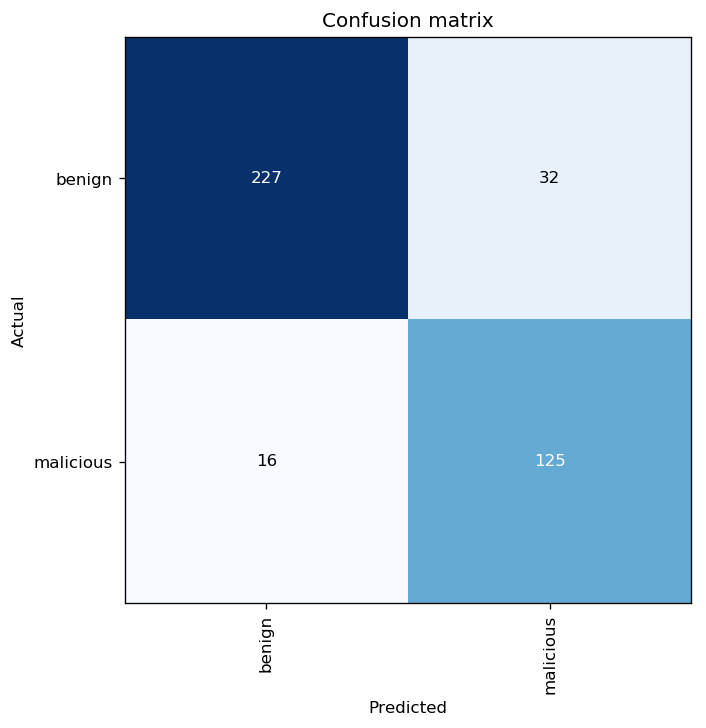

In [625]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [653]:
def get_proc_df(tll):
    """Get processed xs and ys from a tabular `LabelList` with a single value for label such as FloatList.
       For example from `TabularDataBunch.train_ds`.
       :param tll: A tabular `LabelList`. 
       :returns: A tuple of `(x,y)` where `x` is a pandas `DataFrame` and `y` is a numpy array.
    """
    x_vals = np.concatenate([tll.x.codes, tll.x.conts], axis=1)
    x_cols = tll.x.cat_names + tll.x.cont_names
    x_df = pd.DataFrame(data=x_vals, columns=x_cols)[
            [c for c in tll.inner_df.columns if c in x_cols] ] # Retain order
    
    # Reconstruct ys to apply log if specified
    y_vals = np.array([i.obj for i in tll.y])
    return x_df, y_vals

X, y = get_proc_df(data)

# Label target
target_le = LabelEncoder()
y = target_le.fit_transform(y)

In [665]:
X.shape

(1335, 12)

In [654]:
# Validation set
x_vals = np.concatenate([data.valid_dl.x.codes, data.valid_dl.x.conts], axis=1)
x_cols = data.valid_dl.x.cat_names + data.valid_dl.x.cont_names

X_valid = pd.DataFrame(data=x_vals, columns=x_cols)[
    [c for c in data.inner_df.columns if c in x_cols] ] # Retain order

# Reconstruct ys to apply log if specified
y_valid = np.array([i.obj for i in data.valid_dl.y])

# Label target
target_le = LabelEncoder()
y_valid = target_le.fit_transform(y_valid)

In [655]:
data.valid_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x1a350387f0>, device=device(type='cpu'), tfms=[], collate_fn=<function data_collate at 0x1a25a67048>)

  * Initiating Malicious URL Model
  * Training Malicious URL Model


/Users/alistairgillespie/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/alistairgillespie/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


  * Predicting test classes



  * Performance testing:
    Precision - 0.846
    Recall - 0.738
    F1 - 0.788

Confusion matrix:
 [[240  19]
 [ 37 104]]


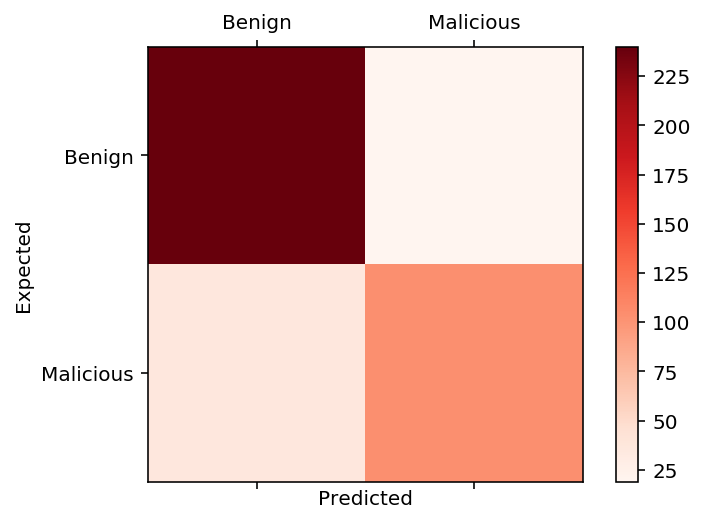

In [671]:
# Parameters for Grid Search
param_grid = {
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
#     'min_samples_splits': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_depth': [1, 4, 6, 8, 10, 14, 18, 22, 24, 26, 30],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [5, 10, 12],
}

# Scoring for Grid Search
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

clf = RandomForestClassifier(
        criterion='entropy')

# Setup base Classifier and Grid Search
print('  * Initiating Malicious URL Model') 
rdf = GridSearchCV(clf, param_grid, scoring=scorers, refit='f1_score',
                   return_train_score=True, n_jobs=4)

# Fit model
print('  * Training Malicious URL Model') 
rdf.fit(X, y);

# Run predictions
print('  * Predicting test classes')     
rfprediction = rdf.predict(X_valid)  # predict output

# Calculate accuracy 
print('\n\n')
print('  * Performance testing:')
print("    Precision - %1.3f" % precision_score(y_valid, rfprediction))
print("    Recall - %1.3f" % recall_score(y_valid, rfprediction))
print("    F1 - %1.3f\n" % f1_score(y_valid, rfprediction))

# Confusion matrix
conf_mat = confusion_matrix(y_true=y_valid, y_pred=rfprediction)
print('Confusion matrix:\n', conf_mat)

labels = ['Benign', 'Malicious']
fig = plt.figure();
ax = fig.add_subplot(111);
cax = ax.matshow(conf_mat, cmap=plt.cm.Reds);
fig.colorbar(cax);
ax.set_xticklabels([''] + labels);
ax.set_yticklabels([''] + labels);
plt.xlabel('Predicted');
plt.ylabel('Expected');

plt.show();

In [ ]:
from sklearn import svm

# Scoring for Grid Search
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(svm.SVC(kernel='linear'),  param_grid, scorers, refit='f1_score')
grid_search.fit(X, y)

# vc = svm.SVC(kernel='linear', C=1).fit(X, y)

# # Fit model
# print('  * Training Malicious URL Model') 
# rdf.fit(X, y);

# Run predictions
print('  * Predicting test classes')     
vcprediction = grid_search.predict(X_valid)  # predict output

# Calculate accuracy 
print('\n\n')
print('  * Performance testing:')
print("    Precision - %1.3f" % precision_score(y_valid, vcprediction))
print("    Recall - %1.3f" % recall_score(y_valid, vcprediction))
print("    F1 - %1.3f\n" % f1_score(y_valid, vcprediction))

# Confusion matrix
conf_mat = confusion_matrix(y_true=y_valid, y_pred=vcprediction)
print('Confusion matrix:\n', conf_mat)

labels = ['Benign', 'Malicious']
fig = plt.figure();
ax = fig.add_subplot(111);
cax = ax.matshow(conf_mat, cmap=plt.cm.Reds);
fig.colorbar(cax);
ax.set_xticklabels([''] + labels);
ax.set_yticklabels([''] + labels);
plt.xlabel('Predicted');
plt.ylabel('Expected');

plt.show();

/Users/alistairgillespie/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [672]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, rfprediction)
roc_auc = auc(false_positive_rate, true_positive_rate)

0.8321147895615981

In [632]:
!pip install xgboost

     |████████████████████████████████| 686kB 198kB/s eta 0:00:01
    ERROR: Complete output from command python setup.py egg_info:
    ERROR: ++ pwd
    + oldpath=/private/var/folders/y8/zcndhz6537vcxmlf9qsdmsr80000gn/T/pip-install-5fjg_84q/xgboost
    + cd ./xgboost/
    + echo darwin18
    + grep -q darwin
    + LIB_XGBOOST=libxgboost.dylib
    + which g++-5
    + which g++-7
    + which g++-8
    + which clang++
    /usr/bin/clang++
    + export CC=clang
    + CC=clang
    + export CXX=clang++
    + CXX=clang++
    + make clean
    sh: line 1: 20009 Abort trap: 6           /Applications/Xcode.app/Contents/Developer/usr/bin/xcodebuild -sdk '' -find make 2> /dev/null
    make: error: unable to find utility "make", not a developer tool or in PATH
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/private/var/folders/y8/zcndhz6537vcxmlf9qsdmsr80000gn/T/pip-install-5fjg_84q/xgboost/setup.py", line 42, in <module>
        LIB_PATH = libpath['fi

In [631]:
import pickle
import xgboost as xgb

import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.datasets import load_iris, load_digits, load_boston

rng = np.random.RandomState(31337)

kf = KFold(n_splits=2, shuffle=True, random_state=rng)
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBClassifier().fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(confusion_matrix(actuals, predictions))

ModuleNotFoundError: No module named 'xgboost'